In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [2]:
run ../util/setupConsole

In [3]:
# low and high temps for gdd/kdd calcs, taken from Butler, et al, 2015, ERL
t_low = 9
t_high = 29

crop = 'Maize'
wxData = 'cpc'

useTrendMethod = True

yearRange = [1981, 2018]

In [4]:
sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [5]:
# load gdd/kdd from cpc temperature data
if wxData == 'cpc':
    gdd = np.full([len(sacksLat), len(sacksLon), (yearRange[1]-yearRange[0]+1)], np.nan)
    kdd = np.full([len(sacksLat), len(sacksLon), (yearRange[1]-yearRange[0]+1)], np.nan)
elif wxData == 'era5':
    gdd = np.full([721, 1440, (yearRange[1]-yearRange[0]+1)], np.nan)
    kdd = np.full([721, 1440, (yearRange[1]-yearRange[0]+1)], np.nan)

for y, year in enumerate(np.arange(yearRange[0], yearRange[1]+1)):
    print('loading gdd/kdd data for %d'%year)
    with gzip.open('%s/kdd-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
        curKdd = pickle.load(f)
        kdd[:, :, y] = curKdd
        
        
    with gzip.open('%s/gdd-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
        curGdd = pickle.load(f)
        gdd[:, :, y] = curGdd
        
# with gzip.open('%s/kdd-%s-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
#     kdd = pickle.load(f)

# with gzip.open('%s/gdd-%s-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
#     gdd = pickle.load(f)
    
# kddWeekly = np.full([kdd.shape[0], kdd.shape[1], (yearRange[1]-yearRange[0]+1), 53], np.full)
# gddWeekly = np.full([gdd.shape[0], gdd.shape[1], (yearRange[1]-yearRange[0]+1), 53], np.full)
# for y, year in enumerate(np.arange(yearRange[0], yearRange[1]+1)):
#     print('loading weekly data for %d'%year)
#     with gzip.open('%s/kdd-weekly-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
#         curKddWeekly = pickle.load(f)

#     with gzip.open('%s/gdd-weekly-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
#         curGddWeekly = pickle.load(f)
    
#     kddWeekly[:, :, y, :] = curKddWeekly
#     gddWeekly[:, :, y, :] = curGddWeekly

with gzip.open('%s/gdd-kdd-lat-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    lat = pickle.load(f)

with gzip.open('%s/gdd-kdd-lon-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    lon = pickle.load(f)


loading gdd/kdd data for 1981
loading gdd/kdd data for 1982
loading gdd/kdd data for 1983
loading gdd/kdd data for 1984
loading gdd/kdd data for 1985
loading gdd/kdd data for 1986
loading gdd/kdd data for 1987
loading gdd/kdd data for 1988
loading gdd/kdd data for 1989
loading gdd/kdd data for 1990
loading gdd/kdd data for 1991
loading gdd/kdd data for 1992
loading gdd/kdd data for 1993
loading gdd/kdd data for 1994
loading gdd/kdd data for 1995
loading gdd/kdd data for 1996
loading gdd/kdd data for 1997
loading gdd/kdd data for 1998
loading gdd/kdd data for 1999
loading gdd/kdd data for 2000
loading gdd/kdd data for 2001
loading gdd/kdd data for 2002
loading gdd/kdd data for 2003
loading gdd/kdd data for 2004
loading gdd/kdd data for 2005
loading gdd/kdd data for 2006
loading gdd/kdd data for 2007
loading gdd/kdd data for 2008
loading gdd/kdd data for 2009
loading gdd/kdd data for 2010
loading gdd/kdd data for 2011
loading gdd/kdd data for 2012
loading gdd/kdd data for 2013
loading gd

In [6]:
if wxData == 'cpc':
    with gzip.open('%s/seasonal-precip-maize-gpcp.dat'%dataDirDiscovery, 'rb') as f:
        seasonalPrecip = pickle.load(f)
elif wxData == 'era5':
    with gzip.open('%s/seasonal-precip-maize-era5.dat'%dataDirDiscovery, 'rb') as f:
        seasonalPrecip = pickle.load(f)

In [7]:
# if wxData == 'cpc':
#     kdd = kdd[:,:,1:]
#     gdd = gdd[:,:,1:]

In [8]:
# calculate gdd and kdd trends from already-loaded cpc tmax and tmin data

if os.path.isfile('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1])) and os.path.isfile('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1])):
    with gzip.open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        kddTrends = pickle.load(f)

    with gzip.open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        gddTrends = pickle.load(f)
else:
    gddTrends = np.full([gdd.shape[0], gdd.shape[1]], np.nan)
    kddTrends = np.full([kdd.shape[0], kdd.shape[1]], np.nan)

    for x in range(gddTrends.shape[0]):
        for y in range(gddTrends.shape[1]):
            nn = np.where(~np.isnan(gdd[x, y, :]))[0]
            if len(nn) == gdd.shape[2]:
                X = sm.add_constant(range(gdd.shape[2]))
                mdl = sm.OLS(gdd[x, y, :], X).fit()
                gddTrends[x, y] = mdl.params[1]

            nn = np.where(~np.isnan(kdd[x, y, :]))[0]
            if len(nn) == kdd.shape[2]:
                X = sm.add_constant(range(kdd.shape[2]))
                mdl = sm.OLS(kdd[x, y, :], X).fit()
                kddTrends[x, y] = mdl.params[1]

    # if a grid cell has no gdd/kdds, trend will be exactly 0 - set to nan
    kddTrends[kddTrends == 0] = np.nan
    gddTrends[gddTrends == 0] = np.nan
    
    with gzip.open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'wb') as f:
        pickle.dump(kddTrends, f)

    with gzip.open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'wb') as f:
        pickle.dump(gddTrends, f)


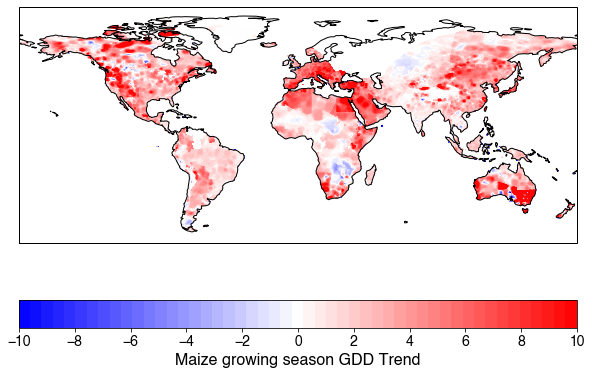

In [9]:
cRange=[-10, 10]
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(gddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 2))
cbar.set_label('%s growing season GDD Trend'%crop)
ax.coastlines()

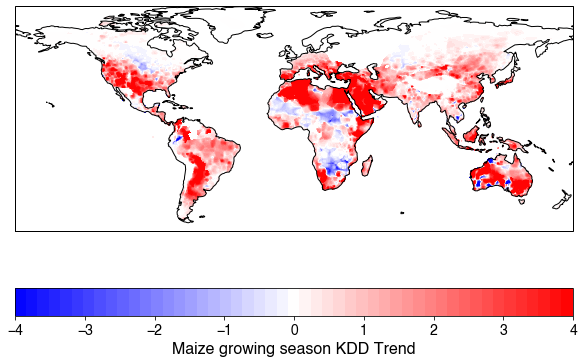

In [10]:
cRange=[-4, 4]
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(kddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
cbar.set_label('%s growing season KDD Trend'%crop)
ax.coastlines()

In [11]:
# kddDetrend = np.full(kdd.shape, np.nan)
# gddDetrend = np.full(gdd.shape, np.nan)

# for xlat in range(kdd.shape[0]):
#     for ylon in range(kdd.shape[1]):
#         nn = np.where((~np.isnan(kdd[xlat, ylon, 0:kdd.shape[2]])) & (~np.isnan(gdd[xlat, ylon, 0:gdd.shape[2]])))[0]
#         if len(nn) == kdd.shape[2]:
#             gddDetrend[xlat, ylon, nn] = scipy.signal.detrend(gdd[xlat, ylon, nn]) / np.linalg.norm(scipy.signal.detrend(gdd[xlat, ylon, nn]))
#             kddDetrend[xlat, ylon, nn] = scipy.signal.detrend(kdd[xlat, ylon, nn]) / np.linalg.norm(scipy.signal.detrend(kdd[xlat, ylon, nn]))
        

In [12]:
# load NASS yield data

nassProd1 = pd.read_csv('%s/nass/nass-maize-production-1961-1974.csv'%dataDirDiscovery)
nassProd2 = pd.read_csv('%s/nass/nass-maize-production-1975-1994.csv'%dataDirDiscovery)
nassProd3 = pd.read_csv('%s/nass/nass-maize-production-1995-2019.csv'%dataDirDiscovery)
nassProd = pd.concat([nassProd1[::-1], nassProd2[::-1], nassProd3[::-1]])

nass1 = pd.read_csv('%s/nass/maize-yield-1961-1978.csv'%dataDirDiscovery)
nass2 = pd.read_csv('%s/nass/maize-yield-1979-1998.csv'%dataDirDiscovery)
nass3 = pd.read_csv('%s/nass/maize-yield-1999-2019.csv'%dataDirDiscovery)

nass = pd.concat([nass1[::-1], nass2[::-1], nass3[::-1]])


In [13]:
usStateAbbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [14]:
nassStates = list(nass['State'])
nassStateAbvs = []
for s in nassStates:
    nassStateAbvs.append(usStateAbbrev[s.lower().title()])
nass['StateAbvs'] = nassStateAbvs

nassProdStates = list(nassProd['State'])
nassProdStateAbvs = []
for s in nassProdStates:
    nassProdStateAbvs.append(usStateAbbrev[s.lower().title()])
nassProd['StateAbvs'] = nassProdStateAbvs

In [15]:
maizeYieldDeepak = []
for year in range(1981, 2008+1):
    curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield/Maize_areaweightedyield_%d.nc'%(dataDirDiscovery, year), decode_cf=False)
    
    if len(maizeYieldDeepak) == 0:
        maizeYieldDeepak = curMaizeYield
    else:
        maizeYieldDeepak = xr.concat([maizeYieldDeepak, curMaizeYield], dim='time')
    
maizeYieldDeepak.load()

# flip latitude axis so top is +90
latDeepak = np.flipud(maizeYieldDeepak.latitude)
lonDeepak = np.roll(maizeYieldDeepak.longitude, int(len(maizeYieldDeepak.longitude)/2), axis=0)
lonDeepak[lonDeepak<0] += 360
maizeYieldDeepak['Data'] = maizeYieldDeepak.Data.transpose('latitude', 'longitude', 'time', 'level')
maizeYieldDeepakData = np.roll(np.flip(maizeYieldDeepak.Data, axis=0), int(len(maizeYieldDeepak.longitude)/2), axis=1)

maizeYieldDeepak['latitude'] = latDeepak
maizeYieldDeepak['longitude'] = lonDeepak
maizeYieldDeepak['Data'] = (('latitude', 'longitude', 'time'), np.squeeze(maizeYieldDeepakData))

In [16]:
def findConsec(data):
    # find longest consequtative sequence of years with yield data
    ptMax = (-1, -1)
    ptCur = (-1, -1)
    for i, val in enumerate(data):
        # start sequence
        if ~np.isnan(val) and ptCur[0] == -1:
            ptCur = (i, -1)
        #end sequence
        elif (np.isnan(val) and ptCur[0] >= 0):
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
            ptCur = (-1, -1)
        # reached end of sequence
        elif i >= len(data)-1 and ptCur[0] >= 0:
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
    return ptMax

In [17]:
minCropYears = 20
minCropYearsDeepak = 20

rebuild=True

if os.path.isfile('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData)) and not rebuild:
    usCounties = pd.read_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))
else:
    usCounties = gpd.read_file('%s/us-county-lat-long/c_02jn20.shp'%dataDirDiscovery)

    usCounties['temp'] = np.full(len(usCounties), np.nan)
    usCounties['tempLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['tempLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['prLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['prLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['gdd'] = np.full(len(usCounties), np.nan)
    usCounties['kdd'] = np.full(len(usCounties), np.nan)
#     usCounties['gddWeekly'] = np.full(len(usCounties), np.nan)
#     usCounties['kddWeekly'] = np.full(len(usCounties), np.nan)
    usCounties['gddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecip'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYield'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNormDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldYears'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProd'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdYears'] = np.full(len(usCounties), np.nan)

    # this is needed to store list in dataframe... kind of hacky
    usCounties = usCounties.astype(object)

    for c in range(usCounties.shape[0]):
        
        if c % 100 == 0:
            print('%.0f %% done'%(c/usCounties.shape[0]*100))
        
        bounds = usCounties['geometry'][c].bounds
        lat1 = bounds[1]
        lat2 = bounds[3]
        lon1 = bounds[0]
        lon2 = bounds[2]

        if lon1 < 0: lon1 += 360
        if lon2 < 0: lon2 += 360

        deepakLatInds = [np.where(abs(latDeepak-lat2) == np.nanmin(abs(latDeepak-lat2)))[0][0],
                   np.where(abs(latDeepak-lat1) == np.nanmin(abs(latDeepak-lat1)))[0][0]]
        deepakLonInds = [np.where(abs(lonDeepak-lon1) == np.nanmin(abs(lonDeepak-lon1)))[0][0],
                   np.where(abs(lonDeepak-lon2) == np.nanmin(abs(lonDeepak-lon2)))[0][0]]
            
        tempLatInds = [np.where(abs(lat-lat2) == np.nanmin(abs(lat-lat2)))[0][0],
                   np.where(abs(lat-lat1) == np.nanmin(abs(lat-lat1)))[0][0]]
        tempLonInds = [np.where(abs(lon-lon1) == np.nanmin(abs(lon-lon1)))[0][0],
                   np.where(abs(lon-lon2) == np.nanmin(abs(lon-lon2)))[0][0]]
        
        prLatInds = [np.where(abs(sacksLat-lat2) == np.nanmin(abs(sacksLat-lat2)))[0][0],
                   np.where(abs(sacksLat-lat1) == np.nanmin(abs(sacksLat-lat1)))[0][0]]
        prLonInds = [np.where(abs(sacksLon-lon1) == np.nanmin(abs(sacksLon-lon1)))[0][0],
                   np.where(abs(sacksLon-lon2) == np.nanmin(abs(sacksLon-lon2)))[0][0]]
        
        if len(tempLatInds) == 0 or len(tempLonInds) == 0 or \
           len(prLatInds) == 0 or len(prLonInds) == 0:
            break

        usCounties['tempLatInds'][c] = tempLatInds
        usCounties['tempLonInds'][c] = tempLonInds
        
        usCounties['prLatInds'][c] = prLatInds
        usCounties['prLonInds'][c] = prLonInds
        
        deepakLatIndsRange = np.arange(min(deepakLatInds), max(deepakLatInds)+1)
        deepakLonIndsRange = np.arange(min(deepakLonInds), max(deepakLonInds)+1)
        
        if len(deepakLatInds) > 1:
            countyYieldDeepak = np.nanmean(maizeYieldDeepak.Data.values[deepakLatIndsRange, :, :], axis=0)
        else:
            countyYieldDeepak = np.squeeze(maizeYieldDeepak.Data.values[deepakLatIndsRange, :, :])
        
        if len(deepakLonInds) > 1:
            countyYieldDeepak = np.nanmean(countyYieldDeepak[deepakLonIndsRange, :], axis=0)
        else:
            countyYieldDeepak = np.squeeze(countyYieldDeepak[deepakLonIndsRange, :])
        
        # add padding so yield array is same length as nass arrays
        countyYieldDeepak = np.pad(countyYieldDeepak, (0, 5), 'constant', constant_values=(np.nan))
        
        tempLatIndsRange = np.arange(min(tempLatInds), max(tempLatInds)+1)
        tempLonIndsRange = np.arange(min(tempLonInds), max(tempLonInds)+1)
        
        prLatIndsRange = np.arange(min(prLatInds), max(prLatInds)+1)
        prLonIndsRange = np.arange(min(prLonInds), max(prLonInds)+1)

        if len(tempLatIndsRange) > 1:
            countyGdd = np.nanmean(gdd[tempLatIndsRange, :, :], axis=0)
            countyKdd = np.nanmean(kdd[tempLatIndsRange, :, :], axis=0)
            
#             countyGddWeekly = np.nanmean(gddWeekly[tempLatIndsRange, :, :, :], axis=0)
#             countyKddWeekly = np.nanmean(kddWeekly[tempLatIndsRange, :, :, :], axis=0)
        else:
            countyGdd = np.squeeze(gdd[tempLatIndsRange, :, :])
            countyKdd = np.squeeze(kdd[tempLatIndsRange, :, :])
            
#             countyGddWeekly = np.squeeze(gddWeekly[tempLatIndsRange, :, :, :])
#             countyKddWeekly = np.squeeze(kddWeekly[tempLatIndsRange, :, :, :])
        
        if len(prLatIndsRange) > 1:
            countyPrecip = np.nanmean(seasonalPrecip[prLatIndsRange, :, :], axis=0)
        else:
            countyPrecip = np.squeeze(seasonalPrecip[prLatIndsRange, :, :])

        if len(tempLonIndsRange) > 1:
            countyGdd = np.nanmean(countyGdd[tempLonIndsRange, :], axis=0)
            countyKdd = np.nanmean(countyKdd[tempLonIndsRange, :], axis=0)
            
#             countyGddWeekly = np.nanmean(countyGddWeekly[tempLonIndsRange, :, :], axis=0)
#             countyKddWeekly = np.nanmean(countyKddWeekly[tempLonIndsRange, :, :], axis=0)
        else:
            countyGdd = np.squeeze(countyGdd[tempLonIndsRange, :])
            countyKdd = np.squeeze(countyKdd[tempLonIndsRange, :])
            
#             countyGddWeekly = np.squeeze(countyGddWeekly[tempLonIndsRange, :, :])
#             countyKddWeekly = np.squeeze(countyKddWeekly[tempLonIndsRange, :, :])
        
        if len(prLonIndsRange) > 1:
            countyPrecip = np.nanmean(countyPrecip[prLonIndsRange, :], axis=0)
        else:
            countyPrecip = np.squeeze(countyPrecip[prLonIndsRange, :])

        curCountyName = usCounties['COUNTYNAME'][c].lower()
        nassYieldCounties = np.array(list(map(str.lower, nass['County'])))
        nassProdCounties = np.array(list(map(str.lower, nassProd['County'])))

        curStateName = usCounties['STATE'][c].lower()
        nassYieldStates = np.array(list(map(str.lower, nass['StateAbvs'])))
        nassProdStates = np.array(list(map(str.lower, nassProd['StateAbvs'])))

        countyIndYield = np.where((curCountyName == nassYieldCounties) & (curStateName == nassYieldStates))[0]
        countyIndProd = np.where((curCountyName == nassProdCounties) & (curStateName == nassProdStates))[0]

        curCountyYieldYears = np.array(list(nass['Year']))
        curCountyYieldYears = curCountyYieldYears[countyIndYield]

        curCountyYield = np.array(list(nass['Value']))
        curCountyYield = curCountyYield[countyIndYield]
        
        curCountyProdYears = np.array(list(nassProd['Year']))
        curCountyProdYears = curCountyProdYears[countyIndProd]
        
        curCountyProd = np.array(list(nassProd['Value']))
        curCountyProd = curCountyProd[countyIndProd]

        yieldYearsUniform = np.arange(1981, 2018+1)
        yieldUniform = np.full(yieldYearsUniform.shape, np.nan)
        yieldUniformDetrend = np.full(yieldYearsUniform.shape, np.nan)
        yieldUniformDetrendNorm = np.full(yieldYearsUniform.shape, np.nan)
        
        for y, year in enumerate(curCountyYieldYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(yieldYearsUniform):
                yieldUniform[indUniform] = curCountyYield[y]
        
        prodYearsUniform = np.arange(1981, 2018+1)
        prodUniform = np.full(prodYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyProdYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(prodYearsUniform):
                prodUniform[indUniform] = float(curCountyProd[y].replace(',', ''))
        
        # find longest consequtative sequence of years with yield data
        ptMax = findConsec(yieldUniform)
        
        if ptMax[1]-ptMax[0]+1 >= minCropYears:
            
            indsNass = np.arange(ptMax[0], ptMax[1])
            
            yieldUniformDetrendNorm[indsNass] = scipy.signal.detrend(yieldUniform[indsNass]) / np.linalg.norm(scipy.signal.detrend(yieldUniform[indsNass]))
            yieldUniformDetrend[indsNass] = scipy.signal.detrend(yieldUniform[indsNass])
            yieldUniform[:ptMax[0]] = np.nan
            yieldUniform[ptMax[1]:] = np.nan
            
            X = sm.add_constant(range(len(yieldUniform[indsNass])))
            mdl = sm.OLS(yieldUniform[indsNass], X).fit()
            usCounties['maizeYieldTrend'][c] = mdl.params[1]
            
            prodUniform[:ptMax[0]] = np.nan
            prodUniform[ptMax[1]:] = np.nan
            
            if len(np.where(np.isnan(prodUniform[ptMax[0]:ptMax[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(prodUniform[ptMax[0]:ptMax[1]+1])))
                mdl = sm.OLS(prodUniform[ptMax[0]:ptMax[1]+1], X).fit()
                usCounties['maizeProdTrend'][c] = mdl.params[1]
        
        usCounties['maizeYieldYears'][c] = yieldYearsUniform
        usCounties['maizeYield'][c] = yieldUniform
        usCounties['maizeYieldDetrend'][c] = yieldUniformDetrend
        usCounties['maizeYieldDetrendNorm'][c] = yieldUniformDetrendNorm
        usCounties['maizeProdYears'][c] = prodYearsUniform
        usCounties['maizeProd'][c] = prodUniform
            
            
        # do the same but with deepak data            
        yieldUniformDetrendDeepak = np.full(yieldYearsUniform.shape, np.nan)
        yieldUniformDetrendNormDeepak = np.full(yieldYearsUniform.shape, np.nan)

        ptMaxDeepak = findConsec(countyYieldDeepak)
        
        if ptMaxDeepak[1]-ptMaxDeepak[0]+1 >= minCropYearsDeepak:

            indsDeepak = np.arange(ptMaxDeepak[0], ptMaxDeepak[1])

            yieldUniformDetrendNormDeepak[indsDeepak] = scipy.signal.detrend(countyYieldDeepak[indsDeepak]) / np.linalg.norm(scipy.signal.detrend(countyYieldDeepak[indsDeepak]))
            yieldUniformDetrendDeepak[indsDeepak] = scipy.signal.detrend(countyYieldDeepak[indsDeepak])
            countyYieldDeepak[:ptMaxDeepak[0]] = np.nan
            countyYieldDeepak[ptMaxDeepak[1]:] = np.nan

            X = sm.add_constant(range(len(countyYieldDeepak[indsDeepak])))
            mdl = sm.OLS(countyYieldDeepak[indsDeepak], X).fit()
            usCounties['maizeYieldTrendDeepak'][c] = mdl.params[1]
        
        usCounties['maizeYieldDeepak'][c] = countyYieldDeepak
        usCounties['maizeYieldDetrendDeepak'][c] = yieldUniformDetrendDeepak
        usCounties['maizeYieldDetrendNormDeepak'][c] = yieldUniformDetrendNormDeepak
        
        countyGdd[countyGdd < 0] = np.nan
        indsGdd = np.where(~np.isnan(countyGdd))[0]
        usCounties['gdd'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gdd'][c] = countyGdd[indsGdd]
        usCounties['gddDetrend'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gddDetrend'][c][indsGdd] = scipy.signal.detrend(countyGdd[indsGdd]) 
        usCounties['gddDetrendNorm'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gddDetrendNorm'][c][indsGdd] = scipy.signal.detrend(countyGdd[indsGdd]) / np.linalg.norm(scipy.signal.detrend(countyGdd[indsGdd]))
        X = sm.add_constant(range(len(countyGdd[indsGdd])))
        mdl = sm.OLS(countyGdd[indsGdd], X).fit()
        usCounties['gddTrend'][c] = mdl.params[1]

        countyKdd[countyKdd < 0] = np.nan
        indsKdd = np.where(~np.isnan(countyKdd))[0]
        usCounties['kdd'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kdd'][c][indsKdd] = countyKdd[indsKdd]
        usCounties['kddDetrend'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kddDetrend'][c][indsKdd] = scipy.signal.detrend(countyKdd[indsKdd]) 
        usCounties['kddDetrendNorm'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kddDetrendNorm'][c][indsKdd] = scipy.signal.detrend(countyKdd[indsKdd]) / np.linalg.norm(scipy.signal.detrend(countyKdd[indsKdd]))
        X = sm.add_constant(range(len(countyKdd[indsKdd])))
        mdl = sm.OLS(countyKdd[indsKdd], X).fit()
        usCounties['kddTrend'][c] = mdl.params[1]

        countyPrecip[countyPrecip < 0] = np.nan
        indsPr = np.where(~np.isnan(countyPrecip))[0]
        usCounties['seasonalPrecip'][c] = np.full(countyPrecip.shape, np.nan)
        usCounties['seasonalPrecip'][c][indsPr] = countyPrecip[indsPr]
        usCounties['seasonalPrecipDetrend'][c] = np.full(countyPrecip.shape, np.nan)
        usCounties['seasonalPrecipDetrend'][c][indsPr] = scipy.signal.detrend(countyPrecip[indsPr]) 
        usCounties['seasonalPrecipDetrendNorm'][c] = np.full(countyPrecip.shape, np.nan)
        usCounties['seasonalPrecipDetrendNorm'][c][indsPr] = scipy.signal.detrend(countyPrecip[indsPr]) / np.linalg.norm(scipy.signal.detrend(countyPrecip[indsPr]))

        X = sm.add_constant(range(len(countyPrecip[indsPr])))
        mdl = sm.OLS(countyPrecip[indsPr], X).fit()
        usCounties['seasonalPrecipTrend'][c] = mdl.params[1]
        
    usCounties.to_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))

0 % done
3 % done
6 % done
9 % done
12 % done
15 % done
18 % done
21 % done
24 % done
27 % done
30 % done
33 % done
36 % done
39 % done
42 % done
45 % done
48 % done
51 % done
54 % done
57 % done
60 % done
63 % done
66 % done
69 % done
72 % done
75 % done
78 % done
81 % done
84 % done
87 % done
90 % done
93 % done
96 % done
99 % done


In [18]:
usCounties = usCounties.drop(columns=['CWA', 'TIME_ZONE', 'FE_AREA'])

In [19]:
# drop all counties with any nans
yieldNans = np.array(list(map(np.isnan, usCounties['maizeYield'])))
yieldTrendNans = np.array(list(map(np.isnan, usCounties['maizeYieldTrend'])))
gddNans = np.array(list(map(np.isnan, usCounties['gdd'])))
kddNans = np.array(list(map(np.isnan, usCounties['kdd'])))
# inds1 = np.where( (np.array([len(np.where((yieldNans[i]==False) & ((gddNans[i]==True) | (kddNans[i]==True)))[0]) for i in range(len(yieldNans))]) > 0))[0]
inds = np.where((yieldTrendNans == True))[0]
# inds = np.union1d(inds1, inds2)

In [20]:
usCounties = usCounties.drop(index=inds)

In [115]:
yt = []
kt = []
pr = []
prod = []

for state in usStateAbbrev.values():
    n =  list(usCounties['STATE']).count(state)
    if n >= 10: 
        p = np.array([np.array(x) for x in np.array(usCounties[usCounties['STATE']==state]['maizeProd'])])
        prod.append(p)
        yt.append(usCounties[usCounties['STATE']==state]['maizeYieldTrendDeepak'].mean().mean())
        kt.append(usCounties[usCounties['STATE']==state]['kddTrend'].mean().mean())
        pr.append(usCounties[usCounties['STATE']==state]['seasonalPrecipTrend'].mean().mean())
        usCounties[usCounties['STATE']==state]['maizeProd']
#         print('%s : %d : yield trend = %.1f : kdd trend = %.1f'%(state, n, \
#                                                                              usCounties[usCounties['STATE']==state]['maizeYieldTrend'].mean().mean(), \
#                                                                              usCounties[usCounties['STATE']==state]['kddTrend'].mean().mean()))
prod = np.array(prod)

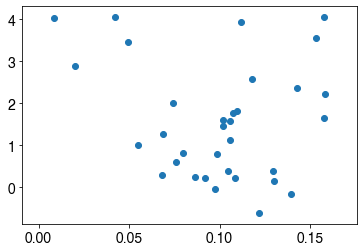

In [116]:
plt.scatter(yt,kt)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


yield trend vs. kdd trend: coef = -0.01, p = 0.00
starting yields vs. kdd trends: coef = -0.13, p = 0.59


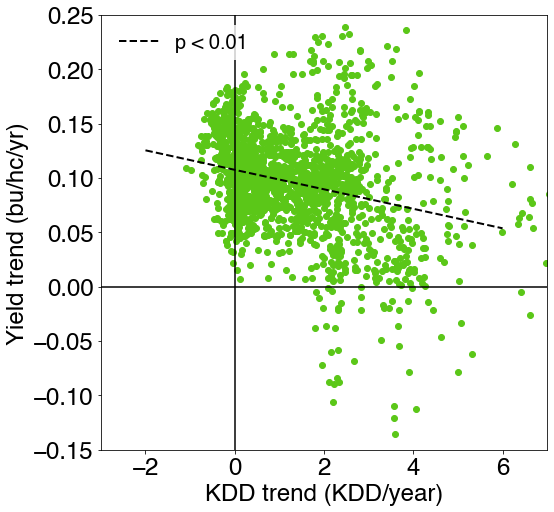

In [117]:
# countyList = usCounties[(usCounties['STATE']=='IA')]
countyList = usCounties

yieldVarDetrend = 'maizeYieldDetrendDeepak'
yieldTrendVar = 'maizeYieldTrendDeepak'
yieldVar = 'maizeYieldDeepak'

gddAnoms = np.array(list(countyList['gddDetrend']))
kddAnoms = np.array(list(countyList['kddDetrend']))
yieldAnoms = np.array(list(countyList[yieldVarDetrend]))

nn = np.where((~np.isnan(gddAnoms)) & (~np.isnan(kddAnoms)) & (~np.isnan(yieldAnoms)))[0]
gddAnoms = gddAnoms[nn]
kddAnoms = kddAnoms[nn]
yieldAnoms = yieldAnoms[nn]

gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
yieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList[yieldVarDetrend]))])))

nn = np.where((~np.isnan(gddAnomAgg)) & (~np.isnan(kddAnomAgg)) & (~np.isnan(yieldAnomAgg)))[0]
gddAnomAgg = gddAnomAgg[nn]
kddAnomAgg = kddAnomAgg[nn]
yieldAnomAgg = yieldAnomAgg[nn]

kddTrendAgg = np.array([x for x in countyList['kddTrend']])
yieldTrendAgg = np.array([x for x in countyList[yieldTrendVar]])

kddTrendAggNorm = (kddTrendAgg-np.nanmin(kddTrendAgg))/np.nanmax(kddTrendAgg)
yieldTrendAggNorm = (yieldTrendAgg-np.nanmin(yieldTrendAgg))/np.nanmax(yieldTrendAgg)

gddValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gdd']))])))
kddValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kdd']))])))
yieldValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList[yieldVar]))])))

nn = np.where((~np.isnan(gddValsAgg)) & (~np.isnan(kddValsAgg)) & (~np.isnan(yieldValsAgg)))[0]
gddValsAgg = gddValsAgg[nn]
kddValsAgg = kddValsAgg[nn]
yieldValsAgg = yieldValsAgg[nn]

startingYields = []
for startingYield in np.array(list(countyList[yieldVar])):
    ind1 = np.where(~np.isnan(startingYield))[0][0]
    ind2 = ind1+5
    if ind2 > len(startingYield): ind2 = len(startingYield)
    startingYields.append(np.nanmean(startingYield[ind1:ind2]))
startingYields = np.array(startingYields)

nn = np.where((~np.isnan(kddTrendAgg)) & (~np.isnan(yieldTrendAgg)) & (~np.isnan(startingYields)))[0]
kddTrendAgg = kddTrendAgg[nn]
yieldTrendAgg = yieldTrendAgg[nn]
startingYields = startingYields[nn]
    
startingYieldsNorm = (startingYields-np.nanmin(startingYields)) / np.nanmax(startingYields)

f, (ax1) = plt.subplots(figsize=(8,8), nrows=1, ncols=1, squeeze=True)

X = sm.add_constant(kddTrendAgg)
mdl1 = sm.RLM(yieldTrendAgg, X).fit()

ax1.set_xlim([-3, 7])
ax1.set_ylim([-.15, .25])
ax1.scatter(kddTrendAgg, yieldTrendAgg, c = '#5bc718')
ax1.plot([-2, 6], mdl1.params[0]+[-2*mdl1.params[1], 6*mdl1.params[1]], '--k', lw=2, label = 'p < 0.01')
ax1.plot([-3, 7], [0, 0], '-k')
ax1.plot([0, 0], [-.15, .25], '-k')
ax1.set_xlabel('KDD trend (KDD/year)', fontsize=24)
ax1.set_ylabel('Yield trend (bu/hc/yr)', fontsize=24)
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(axis='y', labelsize=24)
l1 = ax1.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
plt.savefig('us-kdd-trends-yield-trends.eps', format='eps', dpi=100, bbox_inches = 'tight', pad_inches = 0)

# ax2.scatter(kddValsAgg, yieldValsAgg)
# ax2.set_xlabel('KDD anomaly')
# ax2.set_ylabel('Yield anomaly')

# X = sm.add_constant(startingYieldsNorm)
# mdl2 = sm.RLM(yieldTrendAgg, X).fit()

# ax2.scatter(startingYieldsNorm, yieldTrendAgg, c=kddTrendAggNorm, cmap='Reds')
# ax2.plot([0.05, 0.65], mdl2.params[0]+[0.05*mdl2.params[1], 0.65*mdl2.params[1]], '--k', lw=1, label = 'p = 0.01')
# ax2.set_xlabel('Yield (1981-1985)')
# ax2.set_ylabel('Yield trend')
# l2 = ax2.legend(prop = {'size':14, 'family':'Helvetica'})
# l2.get_frame().set_linewidth(0)


X = sm.add_constant(startingYieldsNorm)
mdl3 = sm.RLM(kddTrendAgg, X).fit()

# ax3.scatter(startingYieldsNorm, kddTrendAgg)
# ax3.plot([0.05, 0.65], mdl3.params[0]+[0.05*mdl3.params[1], 0.65*mdl3.params[1]], '--k', lw=1, label = 'p < 0.01')
# ax3.set_xlabel('Yield (bu/hc; first 5 years)')
# ax3.set_ylabel('KDD trend (KDD/year)')
# l3 = ax3.legend(prop = {'size':14, 'family':'Helvetica'})
# l3.get_frame().set_linewidth(0)


print('yield trend vs. kdd trend: coef = %.2f, p = %.2f'%(mdl1.params[1], mdl1.pvalues[1]))
# print('starting yields vs. yield trends: coef = %.4f, p = %.2f'%(mdl2.params[1], mdl2.pvalues[1]))
print('starting yields vs. kdd trends: coef = %.2f, p = %.2f'%(mdl3.params[1], mdl3.pvalues[1]))


In [118]:
gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
prAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalPrecipDetrend']))])))
yieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrend']))])))
countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(list(countyList['maizeYieldDetrend'])))])))
    

data = {'GDD':gddAnomAgg, \
        'KDD':kddAnomAgg, \
        'Pr':prAnomAgg, 'Pr2':prAnomAgg**2, \
        'County':countyFE, \
        'Yield':yieldAnomAgg}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                           'County', \
                           'Yield'])
mdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     6161.
Date:                Sat, 25 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:02:49   Log-Likelihood:            -2.5437e+05
No. Observations:               59098   AIC:                         5.087e+05
Df Residuals:                   59094   BIC:                         5.088e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0259      0.074     -0.351      0.726      -0.170       0.119
GDD            0.0257      0.001     29.565      0.000       0.024       0.027
KDD           -0.1646      0.002   -103.003      0.000      -0.168      -0.161
Pr            42.6471     29.575      1.442      0.149     -15.319     100.614
==============================================================================
Omnibus:                     5024.916   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9774.567
Skew:                          -0.582   Prob(JB):                         0.00
Kurtosis:                       4.616   Cond. No.                     5.60e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [119]:
gddAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
prAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalPrecipDetrend']))])))
yieldAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrendDeepak']))])))
countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(list(countyList['maizeYieldDetrend'])))])))

nn = np.where((~np.isnan(gddAnomAggDeepak)) & (~np.isnan(kddAnomAggDeepak)) & (~np.isnan(prAnomAggDeepak)) & (~np.isnan(yieldAnomAggDeepak)))[0]

data = {'GDD':gddAnomAggDeepak[nn], \
        'KDD':kddAnomAggDeepak[nn], \
        'Pr':prAnomAggDeepak[nn], 'Pr2':prAnomAggDeepak[nn]**2, \
        'County':countyFE[nn], \
        'Yield':yieldAnomAggDeepak[nn]}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                           'County', \
                           'Yield'])
mdlDeepak = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
mdlDeepak.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     8256.
Date:                Sat, 25 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:02:51   Log-Likelihood:                -83620.
No. Observations:               60575   AIC:                         1.672e+05
Df Residuals:                   60571   BIC:                         1.673e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0285      0.004      7.267      0.000       0.021       0.036
GDD            0.0012   4.65e-05     26.783      0.000       0.001       0.001
KDD           -0.0093   8.16e-05   -114.453      0.000      -0.009      -0.009
Pr            -1.6949      1.583     -1.071      0.284      -4.797       1.407
==============================================================================
Omnibus:                     4105.060   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6255.438
Skew:                          -0.559   Prob(JB):                         0.00
Kurtosis:                       4.109   Cond. No.                     5.78e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.78e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [120]:
stateMdls = {}

# build state models
for state in usStateAbbrev.values():
    
    gddAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['gddDetrend']))])))
    kddAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['kddDetrend']))])))
    prAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['seasonalPrecipDetrend']))])))
    yieldAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['maizeYieldDetrendDeepak']))])))
    
    nn = np.where((~np.isnan(gddAgg)) & (~np.isnan(kddAgg)) & (~np.isnan(prAgg)) & (~np.isnan(yieldAgg)))[0]
    
    if len(nn) > 100:
#         print('building model for %s, n = %d'%(state, len(nn)))
    
        data = {'GDD':gddAgg[nn], \
            'KDD':kddAgg[nn], \
            'Pr':prAgg[nn], 'Pr2':prAgg[nn]**2, \
            'Yield':yieldAgg[nn]}

        df = pd.DataFrame(data, \
                          columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                                   'Yield'])
        stateMdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
        stateMdls[state] = stateMdl

In [121]:
countyFips = np.array(list(countyList['FIPS']))
states = np.array(list(countyList['STATE']))
startingYields = np.array(list(countyList['maizeYield']))
startingYieldsDeepak = np.array(list(countyList['maizeYieldDeepak']))

In [122]:
if not useTrendMethod:

    if os.path.isfile('%s/county-model-data-%s-%s'%(dataDirDiscovery, crop, wxData)):
        with open('%s/county-model-data-%s-%s'%(dataDirDiscovery, crop, wxData), 'rb') as f:
            countyModelData = pickle.load(f)

            countyOutcomes = countyModelData['countyOutcomes']
            countyOutcomesCounty = countyModelData['countyOutcomesCounty']
            countyOutcomesState = countyModelData['countyOutcomesState']
            countyOutcomesDeepak = countyModelData['countyOutcomesDeepak']
            countyGddChg = countyModelData['countyGddChg']
            countyKddChg = countyModelData['countyKddChg']
            countyPrChg = countyModelData['countyPrChg']

            print('loaded %s'%('%s/county-model-data-%s-%s'%(dataDirDiscovery, crop, wxData)))

    else:
        periodLen = range(5, 15)

        countyFips = np.array(list(countyList['FIPS']))
        states = np.array(list(countyList['STATE']))
        startingYields = np.array(list(countyList['maizeYield']))
        startingYieldsDeepak = np.array(list(countyList['maizeYieldDeepak']))

        countyOutcomes = {}
        countyOutcomesDeepak = {}
        countyOutcomesCounty = {}
        countyOutcomesState = {}
        countyGddChg = {}
        countyKddChg = {}
        countyPrChg = {}

        for c, fips in enumerate(countyFips):
            if c % 50 == 0:
                print('%.0f %%'%(c/len(countyFips)*100))

            curCountyOutcomes = []
            curCountyOutcomesDeepak = []
            curCountyOutcomesCounty = []
            curCountyOutcomesState = []
            curCountyGddChg = []
            curCountyKddChg = []
            curCountyPrChg = []

            countyGdd = np.array(list(usCounties['gddDetrend']))[c, :]
            countyKdd = np.array(list(usCounties['kddDetrend']))[c, :]
            countyPr = np.array(list(usCounties['seasonalPrecipDetrend']))[c, :]
            countyYield = np.array(list(usCounties['maizeYieldDetrend']))[c, :]

            nn = np.where((~np.isnan(countyGdd)) & (~np.isnan(countyKdd)) & (~np.isnan(countyPr)) & (~np.isnan(countyYield)))[0]

            countyModelExists = False

            if len(nn) > 10:
                # build county-specific model
                data = {'GDD':countyGdd[nn], \
                        'KDD':countyKdd[nn], \
                        'Pr':countyPr[nn], 'Pr2':countyPr[nn]**2, \
                        'Yield':countyYield[nn]}

                df = pd.DataFrame(data, \
                                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                                           'Yield'])
                countyMdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
                countyModelExists = True

            curCountyGdd = np.array(list(usCounties['gdd']))[c, :]
            curCountyKdd = np.array(list(usCounties['kdd']))[c, :]
            curCountyPr = np.array(list(usCounties['seasonalPrecip']))[c, :]

            curCountyYield = np.array(list(usCounties['maizeYield']))[c, :]
            curCountyYieldDeepak = np.array(list(usCounties['maizeYieldDeepak']))[c, :]

            for p in periodLen:

                curCountyGddStart = curCountyGdd[0:p]
                curCountyKddStart = curCountyKdd[0:p]
                curCountyPrStart = curCountyPr[0:p]

                curCountyGddEnd = curCountyGdd[len(curCountyGdd)-p:]
                curCountyKddEnd = curCountyKdd[len(curCountyKdd)-p:]
                curCountyPrEnd = curCountyPr[len(curCountyPr)-p:]

                XStart = {'GDD':curCountyGddStart, 'KDD':curCountyKddStart, 'Pr':curCountyPrStart, 'Pr2':curCountyPrStart**2, 'County':[c]*len(curCountyGddStart)}
                XEnd = {'GDD':curCountyGddEnd, 'KDD':curCountyKddEnd, 'Pr':curCountyPrEnd, 'Pr2':curCountyPrEnd**2, 'County':[c]*len(curCountyGddEnd)}

                predDeepak1 = mdlDeepak.predict(XStart).mean()
                predDeepak2 = mdlDeepak.predict(XEnd).mean()

                if predDeepak1 != 0:
                    predChgDeepak = (predDeepak2-predDeepak1)/np.nanmean(curCountyYieldDeepak)*100
                else:
                    predChgDeepak = np.nan

                pred1 = mdl.predict(XStart).mean()
                pred2 = mdl.predict(XEnd).mean()

                if pred1 != 0:
                    predChg = (pred2-pred1)/np.nanmean(curCountyYield)*100
                else:
                    predChg = np.nan

                if countyModelExists:
                    predCounty1 = countyMdl.predict(XStart).mean()
                    predCounty2 = countyMdl.predict(XEnd).mean()

                    if predCounty1 != 0:
                        predChgCounty = (predCounty2-predCounty1)/np.nanmean(curCountyYield)*100
                    else:
                        predChgCounty = np.nan
                else:
                    predChgCounty = np.nan

                if states[c] in stateMdls.keys():
                    predState1 = stateMdls[states[c]].predict(XStart).mean()
                    predState2 = stateMdls[states[c]].predict(XEnd).mean()

                    if predState1 != 0:
                        predChgState = (predState2-predState1)/np.nanmean(startingYieldsDeepak)*100
                    else:
                        predChgState = np.nan
                else:
                    predChgState = np.nan

                if predChg < -100 or predChg > 100: predChg = np.nan
                if predChgCounty < -100 or predChgCounty > 100: predChgCounty = np.nan
                if predChgState < -100 or predChgState > 100: predChgState = np.nan
                if predChgDeepak < -100 or predChgDeepak > 100: predChgDeepak = np.nan

                curCountyOutcomes.append(predChg)
                curCountyOutcomesDeepak.append(predChgDeepak)
                curCountyOutcomesCounty.append(predChgCounty)
                curCountyOutcomesState.append(predChgState)

                curCountyGddChg.append(np.nanmean(curCountyGddEnd) - np.nanmean(curCountyGddStart))
                curCountyKddChg.append(np.nanmean(curCountyKddEnd) - np.nanmean(curCountyKddStart))
                curCountyPrChg.append(np.nanmean(curCountyPrEnd) - np.nanmean(curCountyPrStart))

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomes, 0)
            if pval <= 0.05:
                countyOutcomes[c] = np.nanmean(curCountyOutcomes)

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesCounty, 0)
            if pval <= 0.05:
                countyOutcomesCounty[c] = np.nanmean(curCountyOutcomesCounty)

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesState, 0)
            if pval <= 0.05:
                countyOutcomesState[c] = np.nanmean(curCountyOutcomesState)

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesDeepak, 0)
            if pval <= 0.05:
                countyOutcomesDeepak[c] = np.nanmean(curCountyOutcomesDeepak)

            countyGddChg[c] = np.nanmean(curCountyGddChg)
            countyKddChg[c] = np.nanmean(curCountyKddChg)
            countyPrChg[c] = np.nanmean(curCountyPrChg)

            countyModelData = {'countyOutcomes':countyOutcomes, \
                               'countyOutcomesCounty':countyOutcomesCounty, \
                               'countyOutcomesState':countyOutcomesState, \
                               'countyOutcomesDeepak':countyOutcomesDeepak, \
                               'countyGddChg':countyGddChg, \
                               'countyKddChg':countyKddChg, \
                               'countyPrChg':countyPrChg}
            with open('%s/county-model-data-%s-%s'%(dataDirDiscovery, crop, wxData), 'wb') as f:
                pickle.dump(countyModelData, f)

In [123]:
if useTrendMethod:
    
    rebuild = True
    
    if os.path.isfile('%s/county-model-data-trendMethod-%s-%s'%(dataDirDiscovery, crop, wxData)) and not rebuild:
        with open('%s/county-model-data-trendMethod-%s-%s'%(dataDirDiscovery, crop, wxData), 'rb') as f:
            countyModelData = pickle.load(f)

            countyOutcomes = countyModelData['countyOutcomes']
            countyOutcomesCounty = countyModelData['countyOutcomesCounty']
            countyOutcomesState = countyModelData['countyOutcomesState']
            countyOutcomesDeepak = countyModelData['countyOutcomesDeepak']
            countyGddChg = countyModelData['countyGddChg']
            countyKddChg = countyModelData['countyKddChg']
            countyPrChg = countyModelData['countyPrChg']

            print('loaded %s'%('%s/county-model-data-trendMethod-%s-%s'%(dataDirDiscovery, crop, wxData)))

    else:
        
        # how many kdd/gdd/pr slopes to generate by leaving out years
        leaveOutN = 30
        
        countyOutcomes = {}
        countyOutcomesDeepak = {}
        countyOutcomesCounty = {}
        countyOutcomesState = {}
        countyGddChg = {}
        countyKddChg = {}
        countyPrChg = {}

        for c, fips in enumerate(countyFips):
            if c % 50 == 0:
                print('%.0f %%'%(c/len(countyFips)*100))

            curCountyOutcomes = []
            curCountyOutcomesDeepak = []
            curCountyOutcomesCounty = []
            curCountyOutcomesState = []
            curCountyGddChg = []
            curCountyKddChg = []
            curCountyPrChg = []

            countyGdd = np.array(list(usCounties['gddDetrend']))[c, :]
            countyKdd = np.array(list(usCounties['kddDetrend']))[c, :]
            countyPr = np.array(list(usCounties['seasonalPrecipDetrend']))[c, :]
            countyYield = np.array(list(usCounties['maizeYieldDetrend']))[c, :]

            nn = np.where((~np.isnan(countyGdd)) & (~np.isnan(countyKdd)) & (~np.isnan(countyPr)) & (~np.isnan(countyYield)))[0]

            countyModelExists = False

            if len(nn) > 10:
                # build county-specific model
                data = {'GDD':countyGdd[nn], \
                        'KDD':countyKdd[nn], \
                        'Pr':countyPr[nn], 'Pr2':countyPr[nn]**2, \
                        'Yield':countyYield[nn]}

                df = pd.DataFrame(data, \
                                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                                           'Yield'])
                countyMdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
                countyModelExists = True

            curCountyGdd = np.array(list(usCounties['gdd']))[c, :]
            curCountyKdd = np.array(list(usCounties['kdd']))[c, :]
            curCountyPr = np.array(list(usCounties['seasonalPrecip']))[c, :]

            curCountyYield = np.array(list(usCounties['maizeYield']))[c, :]
            curCountyYieldDeepak = np.array(list(usCounties['maizeYieldDeepak']))[c, :]

            for n in range(leaveOutN):
            
                inds = np.arange(0, len(curCountyKdd))
                inds = random.sample(set(inds), len(inds)-2)
                inds.sort()
                         
                X = sm.add_constant(range(len(curCountyKdd[inds])))
                curCountyKddMdl = sm.OLS(curCountyKdd[inds], X).fit()
                curCountyKddInt = curCountyKddMdl.params[0]
                curCountyKddTrend = curCountyKddMdl.params[1]

                X = sm.add_constant(range(len(curCountyGdd[inds])))
                curCountyGDDMdl = sm.OLS(curCountyGdd[inds], X).fit()
                curCountyGddInt = curCountyGDDMdl.params[0]
                curCountyGddTrend = curCountyGDDMdl.params[1]

                X = sm.add_constant(range(len(curCountyPr[inds])))
                curCountyPrMdl = sm.OLS(curCountyPr[inds], X).fit()
                curCountyPrInt = curCountyPrMdl.params[0]
                curCountyPrTrend = curCountyPrMdl.params[1]
                                 
                XStart = {'GDD':[curCountyGddInt], \
                        'KDD':[curCountyKddInt], \
                        'Pr':[curCountyPrInt]}
                XEnd = {'GDD':[(curCountyGddInt+curCountyGddTrend*(2020-1979))], \
                        'KDD':[(curCountyKddInt+curCountyKddTrend*(2020-1979))], \
                        'Pr':[(curCountyPrInt+curCountyPrTrend*(2020-1979))]}

                predDeepak1 = mdlDeepak.predict(XStart).values[0]
                predDeepak2 = mdlDeepak.predict(XEnd).values[0]

                if predDeepak1 != 0:
                    predChgDeepak = (predDeepak2-predDeepak1)/np.nanmean(curCountyYieldDeepak)*100
                else:
                    predChgDeepak = np.nan

                pred1 = mdl.predict(XStart).values[0]
                pred2 = mdl.predict(XEnd).values[0]

                if pred1 != 0:
                    predChg = (pred2-pred1)/np.nanmean(curCountyYield)*100
                else:
                    predChg = np.nan

                if countyModelExists:
                    predCounty1 = countyMdl.predict(XStart).values[0]
                    predCounty2 = countyMdl.predict(XEnd).values[0]

                    if predCounty1 != 0:
                        predChgCounty = (predCounty2-predCounty1)/np.nanmean(curCountyYield)*100
                    else:
                        predChgCounty = np.nan
                else:
                    predChgCounty = np.nan

                if states[c] in stateMdls.keys():
                    predState1 = stateMdls[states[c]].predict(XStart).values[0]
                    predState2 = stateMdls[states[c]].predict(XEnd).values[0]

                    if predState1 != 0:
                        predChgState = (predState2-predState1)/np.nanmean(startingYieldsDeepak)*100
                    else:
                        predChgState = np.nan
                else:
                    predChgState = np.nan

                if predChg < -100 or predChg > 100: predChg = np.nan
                if predChgCounty < -100 or predChgCounty > 100: predChgCounty = np.nan
                if predChgState < -100 or predChgState > 100: predChgState = np.nan
                if predChgDeepak < -100 or predChgDeepak > 100: predChgDeepak = np.nan

                curCountyOutcomes.append(predChg)
                curCountyOutcomesDeepak.append(predChgDeepak)
                curCountyOutcomesCounty.append(predChgCounty)
                curCountyOutcomesState.append(predChgState)

                curCountyGddChg.append(np.nanmean(XEnd['GDD']) - np.nanmean(XStart['GDD']))
                curCountyKddChg.append(np.nanmean(XEnd['KDD']) - np.nanmean(XStart['KDD']))
                curCountyPrChg.append(np.nanmean(XEnd['Pr']) - np.nanmean(XStart['Pr']))

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomes, 0)
            if pval <= 0.05:
                countyOutcomes[c] = curCountyOutcomes

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesCounty, 0)
            if pval <= 0.05:
                countyOutcomesCounty[c] = curCountyOutcomesCounty

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesState, 0)
            if pval <= 0.05:
                countyOutcomesState[c] = curCountyOutcomesState

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesDeepak, 0)
            if pval <= 0.05:
                countyOutcomesDeepak[c] = curCountyOutcomesDeepak
            
            countyGddChg[c] = curCountyGddChg
            countyKddChg[c] = curCountyKddChg
            countyPrChg[c] = curCountyPrChg

        countyModelData = {'countyOutcomes':countyOutcomes, \
                           'countyOutcomesCounty':countyOutcomesCounty, \
                           'countyOutcomesState':countyOutcomesState, \
                           'countyOutcomesDeepak':countyOutcomesDeepak, \
                           'countyGddChg':countyGddChg, \
                           'countyKddChg':countyKddChg, \
                           'countyPrChg':countyPrChg}
        with open('%s/county-model-data-trendMethod-%s-%s'%(dataDirDiscovery, crop, wxData), 'wb') as f:
            pickle.dump(countyModelData, f)

0 %
3 %
5 %
8 %
11 %
14 %
16 %
19 %
22 %
24 %
27 %
30 %
33 %
35 %
38 %
41 %
44 %
46 %
49 %
52 %
54 %
57 %
60 %
63 %
65 %
68 %
71 %
73 %
76 %
79 %
82 %
84 %
87 %
90 %
93 %
95 %
98 %


In [124]:
mapFontSize=30

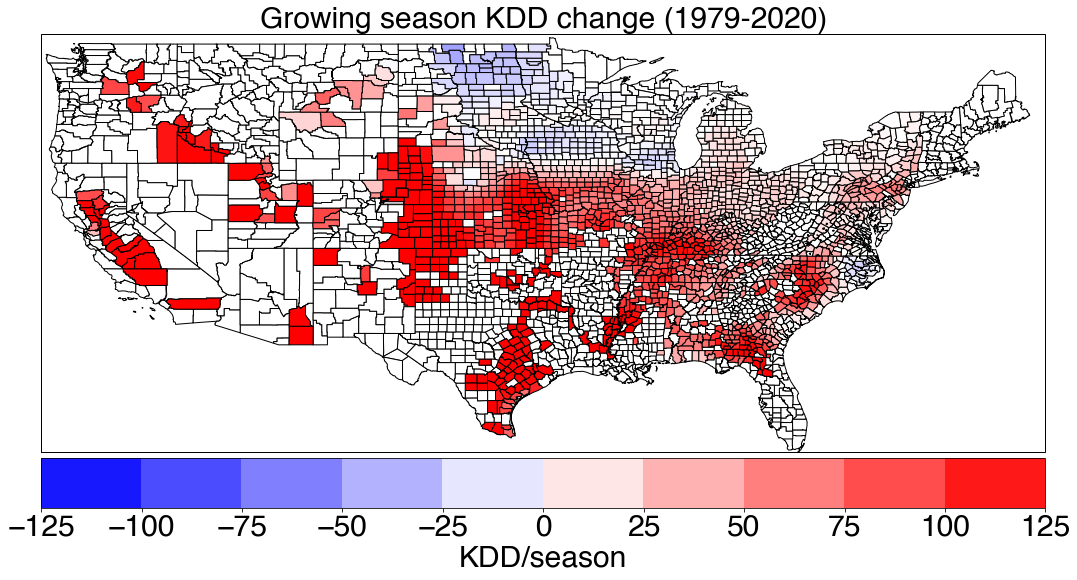

In [125]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

fig = plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-125, vmax=125)
cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyKddChg.keys():
        curKddChg = np.nanmean(countyKddChg[ind[0]])
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curKddChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
ax.set_title('Growing season KDD change (1979-2020)', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-125,126,25), 
             boundaries=np.arange(-125,126,25), orientation='horizontal',
             pad=0.01)
cb.set_label('KDD/season', fontsize=mapFontSize)
cb.ax.tick_params(labelsize=mapFontSize)
# plt.savefig('us-kdd-chg.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

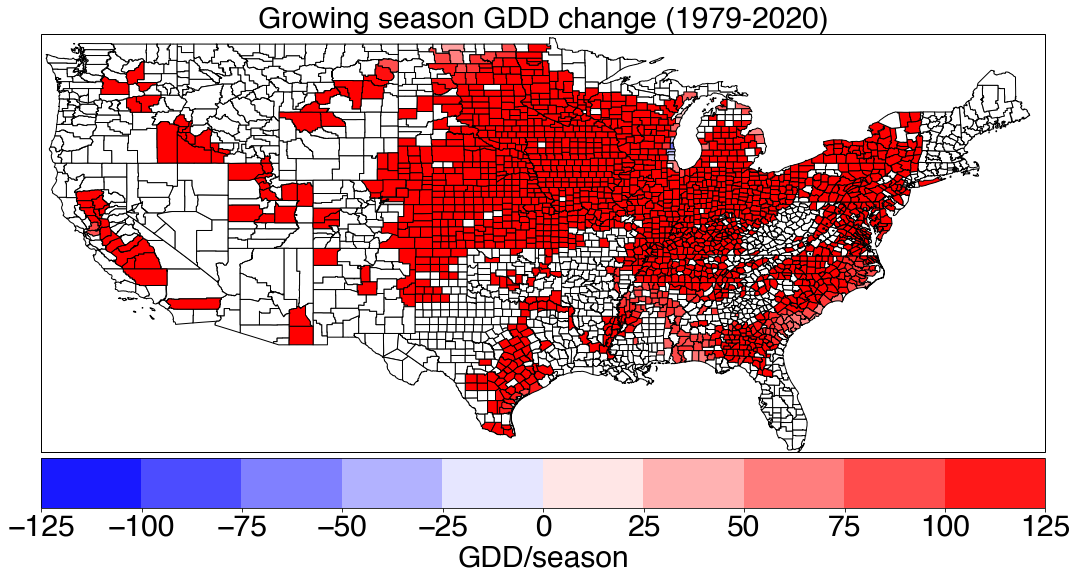

In [126]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-125, vmax=125)
cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyGddChg.keys():
        curGddChg = np.nanmean(countyGddChg[ind[0]])
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curGddChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))

ax.set_title('Growing season GDD change (1979-2020)', fontsize=mapFontSize)        
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-125,126,25), 
             boundaries=np.arange(-125,126,25), orientation='horizontal',
             pad=0.01)
cb.set_label('GDD/season', fontsize=mapFontSize)
cb.ax.tick_params(labelsize=mapFontSize)
# plt.savefig('us-gdd-chg.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

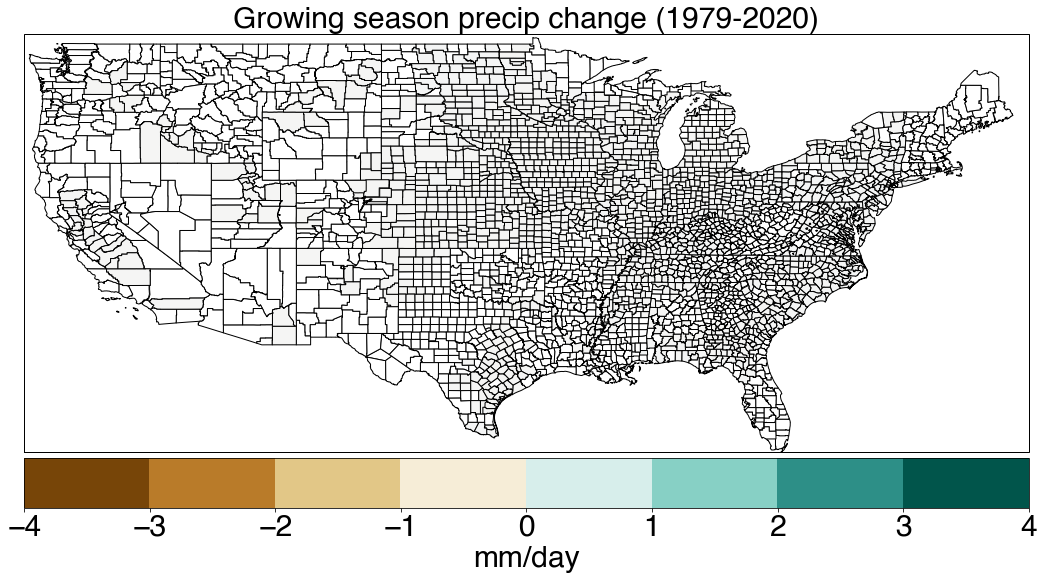

In [127]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-4, vmax=4)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyPrChg.keys():
        curPrChg = np.nanmean(countyPrChg[ind[0]])
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curPrChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))

ax.set_title('Growing season precip change (1979-2020)', fontsize=mapFontSize)    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-4,4.1,1), 
             boundaries=np.arange(-4,4.1,1), orientation='horizontal',
             pad=0.01)
cb.set_label('mm/day', fontsize=mapFontSize)
cb.ax.tick_params(labelsize=mapFontSize)
# plt.savefig('us-pr-chg.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

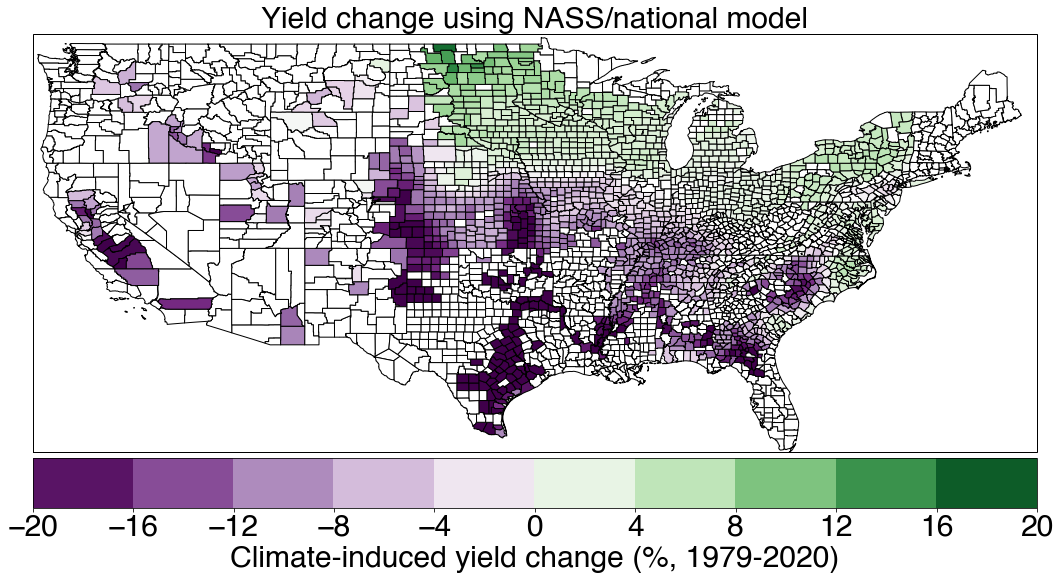

In [128]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-20, vmax=20)
cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomes.keys():
        curYieldChg = np.nanmean(countyOutcomes[ind[0]])
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-20,21,4), 
             boundaries=np.arange(-20,21,4), orientation='horizontal',
             pad=0.01)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Climate-induced yield change (%, 1979-2020)', fontsize=mapFontSize)
# plt.savefig('us-yield-chg-nass-national.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

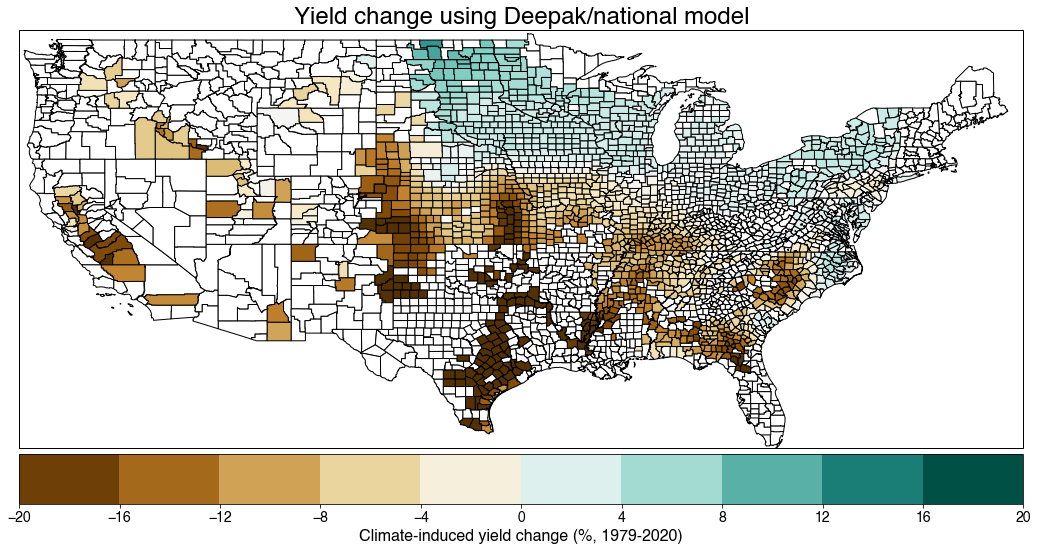

In [129]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-20, vmax=20)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomesDeepak.keys():
        curYieldChg = np.nanmean(countyOutcomesDeepak[ind[0]])
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
ax.set_title('Yield change using Deepak/national model', fontsize=24)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-20,21,4), 
             boundaries=np.arange(-20,21,4), orientation='horizontal',
             pad=0.01)
cb.set_label('Climate-induced yield change (%, 1979-2020)')
# plt.savefig('us-yield-chg-deepak-national.eps', format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

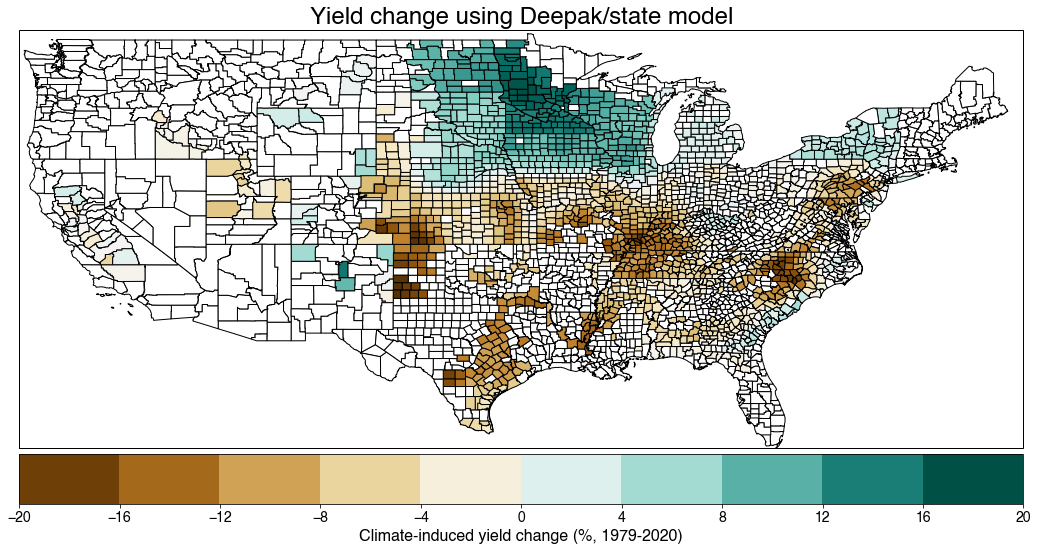

In [130]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-20, vmax=20)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomesState.keys():
        curYieldChg = np.nanmean(countyOutcomesState[ind[0]])
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
ax.set_title('Yield change using Deepak/state model', fontsize=24)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-20,21,4), 
             boundaries=np.arange(-20,21,4), orientation='horizontal',
             pad=0.01)
cb.set_label('Climate-induced yield change (%, 1979-2020)')
plt.show()

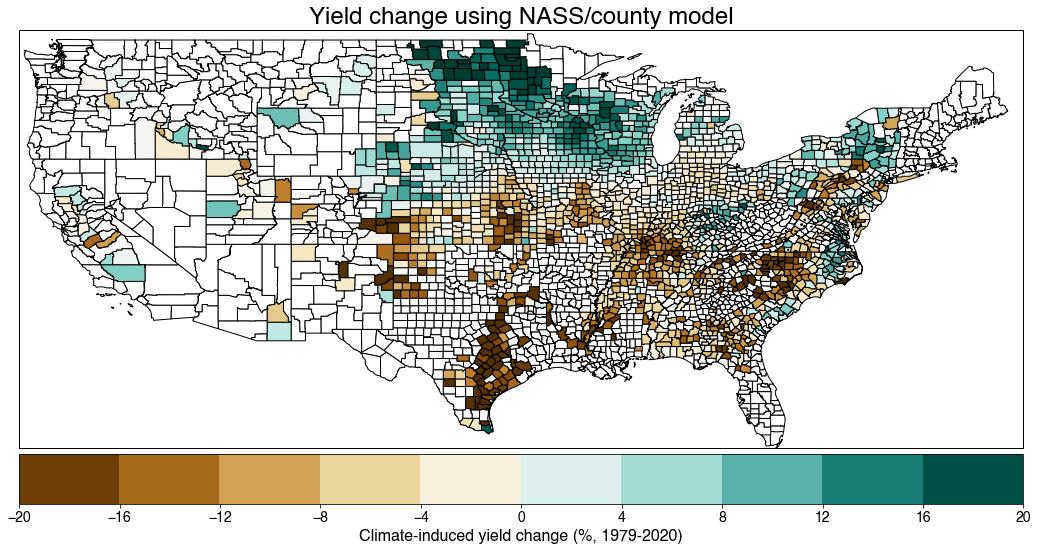

In [131]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-20, vmax=20)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomesCounty.keys():
        curYieldChg = np.nanmean(countyOutcomesCounty[ind[0]])
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
ax.set_title('Yield change using NASS/county model', fontsize=24)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-20,21,4), 
             boundaries=np.arange(-20,21,4), orientation='horizontal',
             pad=0.01)
cb.set_label('Climate-induced yield change (%, 1979-2020)')
plt.show()

In [132]:
startPeriod = range(2, 25)

lowYieldThresh = 25
highYieldThresh = 75

useDeepak = False

if useDeepak:
    yieldVar = 'maizeYieldDeepak'
else:
    yieldVar = 'maizeYield'

allCountyYields = np.array(list(countyList[yieldVar]))
allCountyProd = np.array(list(countyList['maizeProd']))

lowYieldChg = []
allYieldChg = []
highYieldChg = []

lowProd = []
lowProdChg = []
allProdChg = []
allProd = []
highProd = []
highProdChg = []

for spInd, sp in enumerate(startPeriod):        
    startingYields = []
    for startingYield in np.array(list(countyList[yieldVar])):
        indStart = np.where(~np.isnan(startingYield))[0][0]

        ind2 = indStart+sp
        if ind2 > len(startingYield): 
            ind2 = len(startingYield)
        startingYields.append(np.nanmean(startingYield[indStart:ind2]))

    indLow = np.where((startingYields < np.nanpercentile(startingYields, lowYieldThresh)))[0]
    indHigh = np.where((startingYields >= np.nanpercentile(startingYields, highYieldThresh)))[0]

    if useDeepak:
        projYieldChg = countyOutcomesDeepak
    else:
        projYieldChg = countyOutcomes

    for i in indLow:
        if i in projYieldChg.keys():
            lowYieldChg.append(projYieldChg[i])
            lowProdChg.append(np.nanmean(projYieldChg[i])/100*np.nanmean(allCountyProd[i, :]))
            lowProd.append(np.nanmean(allCountyProd[i]))
    for i in indHigh:
        if i in projYieldChg.keys():
            highYieldChg.append(projYieldChg[i])
            highProdChg.append(np.nanmean(projYieldChg[i])/100*np.nanmean(allCountyProd[i, :]))
            highProd.append(np.nanmean(allCountyProd[i]))
    for i in projYieldChg.keys():
        allYieldChg.append(projYieldChg[i])
        allProdChg.append(np.nanmean(projYieldChg[i])/100*np.nanmean(allCountyProd[i, :]))
        allProd.append(np.nanmean(allCountyProd[i]))
        
lowYieldChg = np.nanmean(np.array(lowYieldChg), axis=1)
highYieldChg = np.nanmean(np.array(highYieldChg), axis=1)
allYieldChg = np.nanmean(np.array(allYieldChg), axis=1)

lowProdChg = np.array(lowProdChg)
lowProd = np.array(lowProd)

allProdChg = np.array(allProdChg)
allProd = np.array(allProd)

highProdChg = np.array(highProdChg)
highProd = np.array(highProd)


In [133]:
print(np.nanmedian(lowProdChg)/np.nanmean(lowProd)*100)
print(np.nanmedian(highProdChg)/np.nanmean(highProd)*100)
print(np.nanmedian(allProdChg)/np.nanmean(allProd)*100)

-1.674082991522349
-0.38374573472692186
-0.1773927006803147


In [134]:
print(np.nanmedian(lowYieldChg))
print(np.nanmedian(highYieldChg))
print(np.nanmedian(allYieldChg))

-9.295311141137867
-1.8519832045866467
-2.4712456260963953


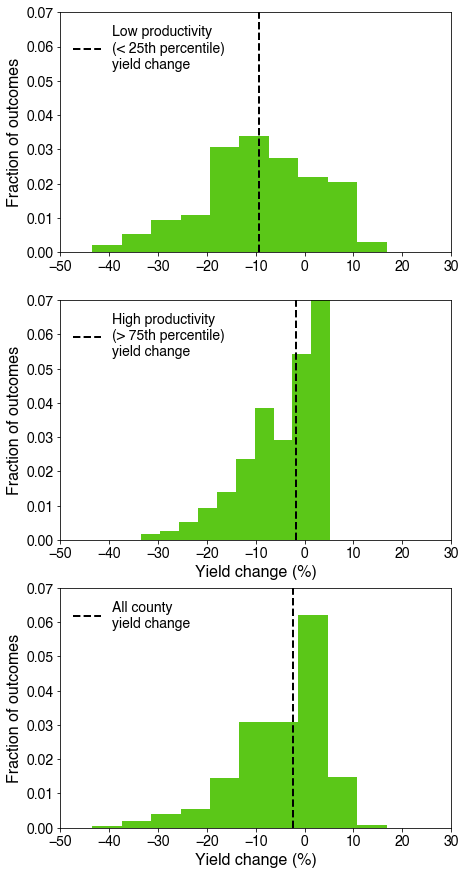

In [135]:
f, (ax1, ax2, ax3) = plt.subplots(figsize=(7, 15), nrows=3, ncols=1, squeeze=True)
ax1.hist(lowYieldChg, density=True, color='#5bc718')
ax1.set_xlim([-50, 30])
ax1.set_ylim([0, .07])
ax1.set_ylabel('Fraction of outcomes')
ax1.plot([np.nanmedian(lowYieldChg), np.nanmedian(lowYieldChg)], [0, 0.07], '--k', lw=2, label='Low productivity\n(< %dth percentile)\nyield change'%lowYieldThresh)
l1 = ax1.legend(prop = {'size':14, 'family':'Helvetica'}, loc='upper left')
l1.get_frame().set_linewidth(0)

ax2.hist(highYieldChg, density=True, color='#5bc718')
ax2.set_xlim([-50, 30])
ax2.set_ylim([0, .07])
ax2.set_ylabel('Fraction of outcomes')
ax2.set_xlabel('Yield change (%)')
ax2.plot([np.nanmedian(highYieldChg), np.nanmedian(highYieldChg)], [0, 0.07], '--k', lw=2, label='High productivity\n(> %dth percentile)\nyield change'%highYieldThresh)
l2 = ax2.legend(prop = {'size':14, 'family':'Helvetica'}, loc='upper left')
l2.get_frame().set_linewidth(0)

ax3.hist(allYieldChg, density=True, color='#5bc718')
ax3.set_xlim([-50, 30])
ax3.set_ylim([0, .07])
ax3.set_ylabel('Fraction of outcomes')
ax3.set_xlabel('Yield change (%)')
ax3.plot([np.nanmedian(allYieldChg), np.nanmedian(allYieldChg)], [0, 0.07], '--k', lw=2, label='All county\nyield change')
l3 = ax3.legend(prop = {'size':14, 'family':'Helvetica'}, loc='upper left')
l3.get_frame().set_linewidth(0)

plt.savefig('us-yield-chg-by-mean-yield.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [136]:
ks_pl_pa = scipy.stats.ks_2samp(lowYieldChg, allYieldChg)
ks_pl_ph = scipy.stats.ks_2samp(lowYieldChg, highYieldChg)
ks_ph_pa = scipy.stats.ks_2samp(highYieldChg, allYieldChg)

print('KS-test: low productivity vs all counties: %.10f'%ks_pl_pa.pvalue)
print('KS-test: low productivity vs high productivity counties: %.10f'%ks_pl_ph.pvalue)
print('KS-test: high productivity vs all counties: %.10f'%ks_ph_pa.pvalue)

KS-test: low productivity vs all counties: 0.0000000000
KS-test: low productivity vs high productivity counties: 0.0000000000
KS-test: high productivity vs all counties: 0.0000000000


In [137]:
periodLen = range(5, 15)

yieldVar = 'maizeYield'

allCountyYields = np.array(list(countyList[yieldVar]))
allCountyProd = np.array(list(countyList['maizeProd']))

allCountyProdChg = np.full([allCountyProd.shape[0], len(periodLen)], np.nan)
allCountyYieldChg = np.full([allCountyProd.shape[0], len(periodLen)], np.nan)

N = allCountyProd.shape[0]*len(periodLen)
n = 0

for pInd, p in enumerate(periodLen):

    startingYields = []
    countyInds = []
    for startingYield in np.array(list(countyList[yieldVar])):
        indStart = np.where(~np.isnan(startingYield))[0][0]
        indEnd = np.where(~np.isnan(startingYield))[0][-1]

        countyInds.append((indStart, indEnd))

        ind2 = indStart+sp
        if ind2 > len(startingYield): 
            ind2 = len(startingYield)
        startingYields.append(np.nanmean(startingYield[indStart:ind2]))

    gddAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['gdd'])))])
    kddAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['kdd'])))])
    prAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])

    gddAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['gdd'])))])
    kddAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['kdd'])))])
    prAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])

    countyYieldsAll = np.array([np.nanmean(allCountyYields[c,:]) for c in range(allCountyYields.shape[0])])
    countyProdsAll = np.array([[np.nansum(allCountyProd[c,:])] for c in range(allCountyProd.shape[0])])

    for c in range(gddAggAllStart.shape[0]):
        XAllStart = {'GDD':gddAggAllStart[c,:], 'KDD':kddAggAllStart[c,:], 'Pr':prAggAllStart[c,:], 'Pr2':prAggAllStart**2}
        XAllEnd = {'GDD':gddAggAllEnd[c,:], 'KDD':kddAggAllEnd[c,:], 'Pr':prAggAllEnd[c,:], 'Pr2':prAggAllEnd[c,:]**2}

        predAll1 = mdl.predict(XAllStart)
        predAll2 = mdl.predict(XAllEnd)

        chg = (predAll2-predAll1)/countyYieldsAll[c]
        allCountyYieldChg[c, pInd] = np.nanmean(chg)
        allCountyProdChg[c, pInd] = np.nanmean(chg*countyProdsAll[c])
        
        if n % 500 == 0:
            print('%.0f %%'%(n/N*100))
        
        n += 1

0 %
3 %
5 %
8 %
11 %
14 %
16 %
19 %
22 %
24 %
27 %
30 %
33 %
35 %
38 %
41 %
44 %
46 %
49 %
52 %
54 %
57 %
60 %
63 %
65 %
68 %
71 %
73 %
76 %
79 %
82 %
84 %
87 %
90 %
93 %
95 %
98 %


In [138]:
startPeriod = range(7, 14)
endPeriod = range(7, 14)

yieldRangeThreshLen = 10
lowYieldThresh = range(20,20+yieldRangeThreshLen)
highYieldThresh = range(70,70+yieldRangeThreshLen)

pl = []
ph = []
pa = []
weightedProdChg = []

N = yieldRangeThreshLen*len(startPeriod)*len(endPeriod)
n = 0

useDeepak = True

if useDeepak:
    yieldVar = 'maizeYieldDeepak'
else:
    yieldVar = 'maizeYield'

allCountyYields = np.array(list(countyList[yieldVar]))
allCountyProd = np.array(list(countyList['maizeProd']))

for r in range(yieldRangeThreshLen):

    for sp in startPeriod:
        
        startingYields = []
        countyInds = []
        for startingYield in np.array(list(countyList[yieldVar])):
            indStart = np.where(~np.isnan(startingYield))[0][0]
            indEnd = np.where(~np.isnan(startingYield))[0][-1]

            countyInds.append((indStart, indEnd))

            ind2 = indStart+sp
            if ind2 > len(startingYield): 
                ind2 = len(startingYield)
            startingYields.append(np.nanmean(startingYield[indStart:ind2]))

        indLow = np.where((startingYields < np.nanpercentile(startingYields, lowYieldThresh[r])))[0]
        indHigh = np.where((startingYields >= np.nanpercentile(startingYields, highYieldThresh[r])))[0]

        for ep in endPeriod:
            
            if n % 100 == 0:
                print('%.0f %%'%(n/N*100))
            
            n += 1
            
            gddAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['gdd']))[indLow])])))
            kddAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['kdd']))[indLow])])))
            prAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indLow])])))
            countyFELowStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in indLow])))
            
            gddAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['gdd']))[indLow])])))
            kddAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['kdd']))[indLow])])))
            prAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indLow])])))
            countyFELowEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in indLow])))

            gddAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['gdd'])))])))
            kddAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['kdd'])))])))
            prAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])))
            countyFEAllStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in range(np.array(list(usCounties['gdd'])).shape[0])])))

            gddAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['gdd'])))])))
            kddAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['kdd'])))])))
            prAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])))
            countyFEAllEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in range(np.array(list(usCounties['gdd'])).shape[0])])))

            gddAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['gdd']))[indHigh])])))
            kddAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['kdd']))[indHigh])])))
            prAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indHigh])])))
            countyFEHighStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in indHigh])))

            gddAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['gdd']))[indHigh])])))
            kddAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['kdd']))[indHigh])])))
            prAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indHigh])])))
            countyFEHighEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in indHigh])))
            
            countyYieldsLow = np.array([np.nanmean(allCountyYields[c,:]) for c in indLow])
            countyYieldsHigh = np.array([np.nanmean(allCountyYields[c,:]) for c in indHigh])
            countyYieldsAll = np.array([np.nanmean(allCountyYields[c,:]) for c in range(allCountyYields.shape[0])])

            XLowStart = {'GDD':gddAggLowStart, 'KDD':kddAggLowStart, 'Pr':prAggLowStart, 'Pr2':prAggLowStart**2, 'County':countyFELowStart}
            XLowEnd = {'GDD':gddAggLowEnd, 'KDD':kddAggLowEnd, 'Pr':prAggLowEnd, 'Pr2':prAggLowEnd**2, 'County':countyFELowEnd}
            XHighStart = {'GDD':gddAggHighStart, 'KDD':kddAggHighStart, 'Pr':prAggHighStart, 'Pr2':prAggHighStart**2, 'County':countyFEHighStart}
            XHighEnd = {'GDD':gddAggHighEnd, 'KDD':kddAggHighEnd, 'Pr':prAggHighEnd, 'Pr2':prAggHighEnd**2, 'County':countyFEHighEnd}
            XAllStart = {'GDD':gddAggAllStart, 'KDD':kddAggAllStart, 'Pr':prAggAllStart, 'Pr2':prAggAllStart**2, 'County':countyFEAllStart}
            XAllEnd = {'GDD':gddAggAllEnd, 'KDD':kddAggAllEnd, 'Pr':prAggAllEnd, 'Pr2':prAggAllEnd**2, 'County':countyFEAllEnd}

            if useDeepak:
                predLow1 = mdlDeepak.predict(XLowStart).mean()
                predLow2 = mdlDeepak.predict(XLowEnd).mean()
            else:
                predLow1 = mdl.predict(XLowStart).mean()
                predLow2 = mdl.predict(XLowEnd).mean()
            if predLow1 > 0 and predLow2 > 0:
                predLow = (predLow2-predLow1)/np.nanmean(countyYieldsLow)*100
                if predLow < -100 or predLow > 500:
                    predLow = np.nan
            else:
                predLow = np.nan

            if useDeepak:
                predHigh1 = mdlDeepak.predict(XHighStart).mean()
                predHigh2 = mdlDeepak.predict(XHighEnd).mean()
            else:
                predHigh1 = mdl.predict(XHighStart).mean()
                predHigh2 = mdl.predict(XHighEnd).mean()
            if predHigh1 > 0 and predHigh2 > 0:
                predHigh = (predHigh2-predHigh1)/np.nanmean(countyYieldsHigh)*100
                if predHigh < -100 or predHigh > 500:
                    predHigh = np.nan
            else:
                predHigh = np.nan

            if useDeepak:
                predAll1 = mdlDeepak.predict(XAllStart).mean()
                predAll2 = mdlDeepak.predict(XAllEnd).mean()
            else:
                predAll1 = mdl.predict(XAllStart).mean()
                predAll2 = mdl.predict(XAllEnd).mean()
            if predAll1 > 0 and predAll2 > 0:
                predAll = (predAll2-predAll1)/np.nanmean(countyYieldsAll)*100
                if predAll < -100 or predAll > 500:
                    predAll = np.nan
            else:
                predAll = np.nan

            pl.append(predLow)
            ph.append(predHigh)
            pa.append(predAll)

pl = np.array(pl)
ph = np.array(ph)
pa = np.array(pa)

0 %
20 %
41 %
61 %
82 %


In [139]:
len(ph)

490

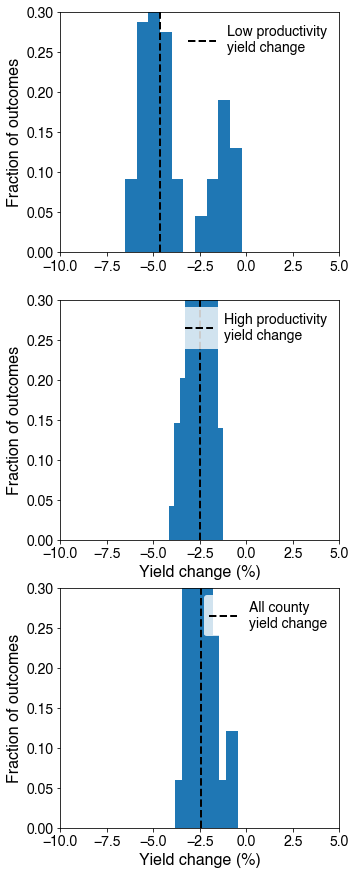

In [140]:
f, (ax1, ax2, ax3) = plt.subplots(figsize=(5, 15), nrows=3, ncols=1, squeeze=True)
ax1.hist(pl, density=True)
ax1.set_xlim([-10, 5])
ax1.set_ylim([0, .3])
ax1.set_ylabel('Fraction of outcomes')
ax1.plot([np.nanmedian(pl), np.nanmedian(pl)], [0, 0.3], '--k', lw=2, label='Low productivity\nyield change')
l1 = ax1.legend(prop = {'size':14, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)

ax2.hist(ph, density=True)
ax2.set_xlim([-10, 5])
ax2.set_ylim([0, .3])
ax2.set_ylabel('Fraction of outcomes')
ax2.set_xlabel('Yield change (%)')
ax2.plot([np.nanmedian(ph), np.nanmedian(ph)], [0, 0.3], '--k', lw=2, label='High productivity\nyield change')
l2 = ax2.legend(prop = {'size':14, 'family':'Helvetica'})
l2.get_frame().set_linewidth(0)

ax3.hist(pa, density=True)
ax3.set_xlim([-10, 5])
ax3.set_ylim([0, .3])
ax3.set_ylabel('Fraction of outcomes')
ax3.set_xlabel('Yield change (%)')
ax3.plot([np.nanmedian(pa), np.nanmedian(pa)], [0, 0.3], '--k', lw=2, label='All county\nyield change')
l3 = ax3.legend(prop = {'size':14, 'family':'Helvetica'})
l3.get_frame().set_linewidth(0)

In [141]:
periodLen = range(5, 15)

yieldVar = 'maizeYield'

allCountyYields = np.array(list(countyList[yieldVar]))
allCountyProd = np.array(list(countyList['maizeProd']))

allCountyProdChg = np.full([allCountyProd.shape[0], len(periodLen)], np.nan)
allCountyYieldChg = np.full([allCountyProd.shape[0], len(periodLen)], np.nan)

N = allCountyProd.shape[0]*len(periodLen)
n = 0

for pInd, p in enumerate(periodLen):

    startingYields = []
    countyInds = []
    for startingYield in np.array(list(countyList[yieldVar])):
        indStart = np.where(~np.isnan(startingYield))[0][0]
        indEnd = np.where(~np.isnan(startingYield))[0][-1]

        countyInds.append((indStart, indEnd))

        ind2 = indStart+sp
        if ind2 > len(startingYield): 
            ind2 = len(startingYield)
        startingYields.append(np.nanmean(startingYield[indStart:ind2]))

    gddAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['gdd'])))])
    kddAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['kdd'])))])
    prAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])

    gddAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['gdd'])))])
    kddAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['kdd'])))])
    prAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])

    countyYieldsAll = np.array([np.nanmean(allCountyYields[c,:]) for c in range(allCountyYields.shape[0])])
    countyProdsAll = np.array([[np.nansum(allCountyProd[c,:])] for c in range(allCountyProd.shape[0])])

    for c in range(gddAggAllStart.shape[0]):
        XAllStart = {'GDD':gddAggAllStart[c,:], 'KDD':kddAggAllStart[c,:], 'Pr':prAggAllStart[c,:], 'Pr2':prAggAllStart**2}
        XAllEnd = {'GDD':gddAggAllEnd[c,:], 'KDD':kddAggAllEnd[c,:], 'Pr':prAggAllEnd[c,:], 'Pr2':prAggAllEnd[c,:]**2}

        predAll1 = mdl.predict(XAllStart)
        predAll2 = mdl.predict(XAllEnd)

        chg = (predAll2-predAll1)/countyYieldsAll[c]
        allCountyYieldChg[c, pInd] = np.nanmean(chg)
        allCountyProdChg[c, pInd] = np.nanmean(chg*countyProdsAll[c])
        
        if n % 500 == 0:
            print('%.0f %%'%(n/N*100))
        
        n += 1

0 %
3 %
5 %
8 %
11 %
14 %
16 %
19 %
22 %
24 %
27 %
30 %
33 %
35 %
38 %
41 %
44 %
46 %
49 %
52 %
54 %
57 %
60 %
63 %
65 %
68 %
71 %
73 %
76 %
79 %
82 %
84 %
87 %
90 %
93 %
95 %
98 %


In [142]:
print('%.2f'%(np.nansum(np.nanmean(allCountyProdChg, axis=1))/np.nansum(allCountyProd)*100))
print('%.2f'%(np.nanmean(np.nanmean(allCountyYieldChg, axis=1)/np.nanmean(allCountyYields, axis=1))*100))

0.21
-0.02
